# Demo: Bayesian Linear Regression
This Jupyter notebook accompanies Lecture 8 of the class Fundamentals of Machine Learning (FML).
By loading it in Jupyter or Jupyter Lab you can rerun it on your own and also modify it.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline

In [3]:
n_sample_funcs = 5
n_plot_std = 1   # number of STD's to plot (shaeded areas)
my_fig_size = (12,5)   # 2 plots, was: (10,4)
my_fig_size_single = (8,6)   # 1 plot
np.random.seed(123456)

## Simple Bayesian Linear Regression

### Prior distribution

We start with a very simple example: Consider 1D Bayesian linear regression with a single parameter $w \in \mathbb{R}$ (the slope of the graph). As the prior distribution on $w$ we use $\mathcal{N}(0,1)$.

In [4]:
w_prior_mean = 0
w_prior_var = 1
w_prior_std = np.sqrt(w_prior_var)   # Standard deviation

To illustrate the situation we plot the probability density function (pdf) of the prior distribution (on the left).  On the right, we illustrate the induced distribution over the space of linear functions $x \mapsto w \cdot x$.

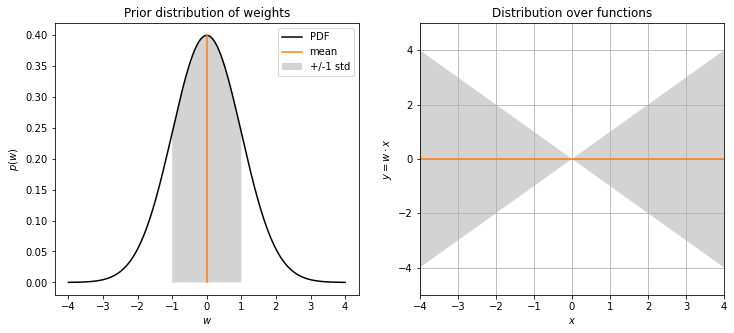

In [5]:
w_prior = norm(loc=w_prior_mean, scale=np.sqrt(w_prior_var))   # normal random variable

# plot of w PDF
fig = plt.figure(figsize=my_fig_size)
ax1 = plt.subplot(1,2,1)

# PDF:
ws = np.linspace(-4,4,1000)
ws_pdf = w_prior.pdf(ws)
plt.plot(ws, ws_pdf, 'black', label='PDF')
# mean:
plt.plot([w_prior_mean, w_prior_mean], [0, w_prior.pdf(w_prior_mean)],'tab:orange', label='mean')   # plotting the mean
# std:
w_std_range = n_plot_std*w_prior_std
ws_std = np.linspace(-w_std_range,w_std_range,100)
ws_std_pdf = w_prior.pdf(ws_std)
plt.fill_between(ws_std,0,ws_std_pdf,facecolor='lightgrey',label='+/-1 std')

plt.xlabel('$w$')
plt.ylabel('$p(w)$')
plt.title('Prior distribution of weights')
plt.legend()

# plot of functions
ax2 = plt.subplot(1,2,2)
xs = np.linspace(-4,4,1000)
plt.plot(xs,w_prior_mean*xs,'tab:orange')
plt.fill_between(xs,n_plot_std*w_prior_std*xs,-1*n_plot_std*w_prior_std*xs,facecolor='lightgrey')
plt.ylim([-5,5])
plt.xlabel('$x$')
plt.ylabel('$y=w\cdot x$')
plt.grid('on')
plt.xlim([-4,4])
_ = plt.title('Distribution over functions')

Let's now add some samples.

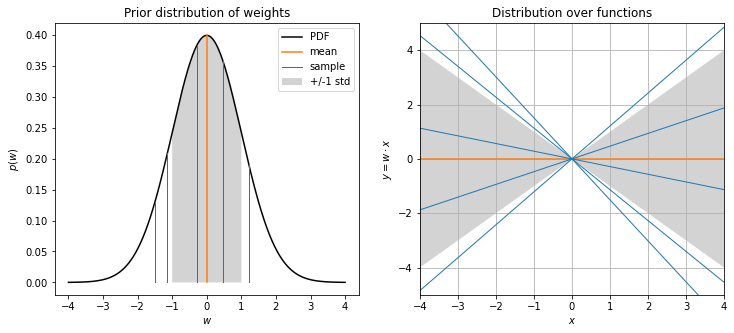

In [6]:
# adding samples
for i in range(n_sample_funcs):
    w_sample = w_prior.rvs(size=1)
    line, = ax1.plot(w_sample[0]*np.array([1., 1.]), np.array([0., w_prior.pdf(w_sample)[0]]), 'tab:blue', lw=1)
    ax2.plot(xs, w_sample*xs, 'tab:blue', lw=1)

line.set_label('sample')
ax1.legend()
fig

Note the spread of the sampled functions on the right.

---

### Posterior (updating with first data point)

We now update the prior with data to arrive at the posterior. For simplicity we generate data from the target function 
$f(x)=0.5\cdot x$, assuming for the likelihood Gaussian noise with mean 0 and variance 1.

In [7]:
noise_var = 1

First, consider only one data point.

In [8]:
x_meas1 = 2
y_meas1 = 0.5*x_meas1

Using Bayes rule, we arrive at the posterior distribution, again a normal distribution (on $w$), 
though with new mean and variance.

In [9]:
w_post1_var = 1/(1/w_prior_var + 1/noise_var*x_meas1**2)
w_post1_mean = w_post1_var/w_prior_var*w_prior_mean + w_post1_var/noise_var*x_meas1*y_meas1
w_post1_std = np.sqrt(w_post1_var)   

We now plot the pdf of the posterior distribution together with the likelihood (of the data point).
Furthermore, we draw some samples from the posterior distribution and plot the induced functions.

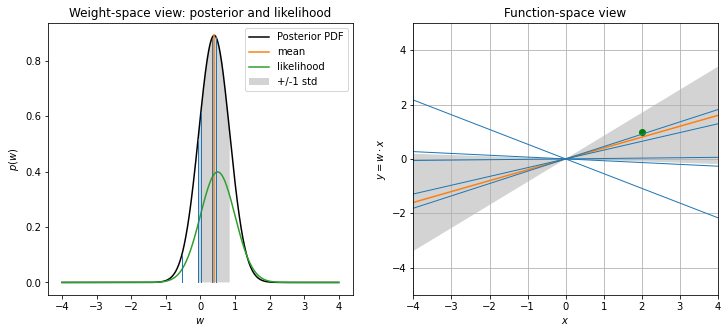

In [10]:
w_post1 = norm(loc=w_post1_mean, scale=np.sqrt(w_post1_var))

# plot of w PDF
fig2 = plt.figure(figsize=my_fig_size)
ax1 = plt.subplot(1,2,1)

# PDF:
ws = np.linspace(-4,4,1000)
ws_post1_pdf = w_post1.pdf(ws)
plt.plot(ws, ws_post1_pdf, 'black', label='Posterior PDF')
# mean:
plt.plot([w_post1_mean, w_post1_mean], [0, w_post1.pdf(w_post1_mean)],'tab:orange', label='mean')   # plotting the mean
# std:
w_std_range = n_plot_std*w_post1_std
ws_std = np.linspace(-w_std_range+w_post1_mean,w_std_range+w_post1_mean,100)
ws_std_pdf = w_post1.pdf(ws_std)
plt.fill_between(ws_std,0,ws_std_pdf,facecolor='lightgrey',label='+/-1 std')
# likelihood
ws_likelihood1 = 1/np.sqrt(2*np.pi*noise_var)*np.exp(-(y_meas1-x_meas1*ws)**2/(2*noise_var))
plt.plot(ws, ws_likelihood1,'tab:green', label='likelihood')

#plt.xlim([-2.,2.])   # uncomment for zoomed-in view
plt.xlabel('$w$')
plt.ylabel('$p(w)$')
plt.title('Weight-space view: posterior and likelihood')


# plot of functions
ax2 = plt.subplot(1,2,2)
xs = np.linspace(-4,4,1000)
plt.plot(xs,w_post1_mean*xs,'tab:orange')
plt.fill_between(xs,(n_plot_std*w_post1_std+w_post1_mean)*xs,(-1*n_plot_std*w_post1_std+w_post1_mean)*xs,facecolor='lightgrey')
plt.plot(x_meas1, y_meas1, 'og')
plt.ylim([-5,5])
plt.xlabel('$x$')
plt.ylabel('$y=w\cdot x$')
plt.grid('on')
plt.xlim([-4,4])
_ = plt.title('Function-space view')


# Set to True for plotting samples
if True :
    # adding samples
    for i in range(n_sample_funcs):
        w_sample = w_post1.rvs(size=1)
        line, = ax1.plot(w_sample[0]*np.array([1., 1.]), np.array([0., w_post1.pdf(w_sample)[0]]), 'tab:blue', lw=1)
        ax2.plot(xs, w_sample*xs, 'tab:blue', lw=1)

ax1.legend()
#endif

Observe that mode of the posterior is away from 0 (but not as far as the mode of the likelihood) and that the
bump got tighter. Furthermore, the spread of the sampled functions on the right got also smaller.

### Posterior (updating with second data point)

We now add a second data point.

In [11]:
x_meas2 = 3
y_meas2 = 0.5*x_meas2

The posterior now replaces the role of the prior and using Bayes rule we update the distribution again with the likelihood
to arrive at the new posterior.

In [12]:
w_post2_var = 1/(1/w_post1_var + 1/noise_var*x_meas2**2)
w_post2_mean = w_post2_var/w_post1_var*w_post1_mean + w_post2_var/noise_var*x_meas2*y_meas2
w_post2_std = np.sqrt(w_post2_var) 

Again, we plot the posterior pdf, the likelihood as well as some samples from the posterior 
(or rather the induced functions induced by the samples).

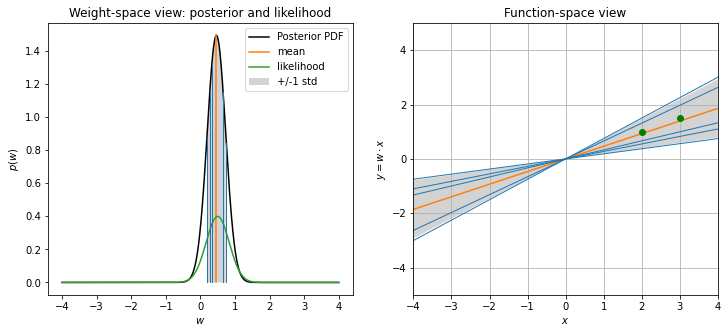

In [13]:
w_post2 = norm(loc=w_post2_mean, scale=np.sqrt(w_post2_var))

# plot of w PDF
fig3 = plt.figure(figsize=my_fig_size)
ax1 = plt.subplot(1,2,1)

# PDF:
ws = np.linspace(-4,4,1000)
ws_post2_pdf = w_post2.pdf(ws)
plt.plot(ws, ws_post2_pdf, 'black', label='Posterior PDF')
# mean:
plt.plot([w_post2_mean, w_post2_mean], [0, w_post2.pdf(w_post2_mean)],'tab:orange', label='mean')   # plotting the mean
# std:
w_std_range = n_plot_std*w_post2_std
ws_std = np.linspace(-w_std_range+w_post2_mean,w_std_range+w_post2_mean,100)
ws_std_pdf = w_post2.pdf(ws_std)
plt.fill_between(ws_std,0,ws_std_pdf,facecolor='lightgrey',label='+/-1 std')
# likelihood
ws_likelihood2 = 1/np.sqrt(2*np.pi*noise_var)*np.exp(-(y_meas2-x_meas2*ws)**2/(2*noise_var))
plt.plot(ws, ws_likelihood2,'tab:green', label='likelihood')

#plt.xlim([-2.,2.])   # uncomment for zoomed-in view
plt.xlabel('$w$')
plt.ylabel('$p(w)$')
plt.title('Weight-space view: posterior and likelihood')


# plot of functions
ax2 = plt.subplot(1,2,2)
xs = np.linspace(-4,4,1000)
plt.plot(xs,w_post2_mean*xs,'tab:orange')
plt.fill_between(xs,(n_plot_std*w_post2_std+w_post2_mean)*xs,(-1*n_plot_std*w_post2_std+w_post2_mean)*xs,facecolor='lightgrey')
plt.plot(x_meas1, y_meas1, 'og')
plt.plot(x_meas2, y_meas2, 'og')
plt.ylim([-5,5])
plt.xlabel('$x$')
plt.ylabel('$y=w\cdot x$')
plt.grid('on')
plt.xlim([-4,4])
_ = plt.title('Function-space view')


# Set to True for plotting samples
if True :
    # adding samples
    for i in range(n_sample_funcs):
        w_sample = w_post2.rvs(size=1)
        line, = ax1.plot(w_sample[0]*np.array([1., 1.]), np.array([0., w_post2.pdf(w_sample)[0]]), 'tab:blue', lw=1)
        ax2.plot(xs, w_sample*xs, 'tab:blue', lw=1)

ax1.legend()
#endif

---

## Bayesian Linear Regression with Nonlinear Features
We now consider Bayesian Linear Regression with (nonlinear) transformation of the input. Note that similarly to linear regression using the maximum likelihood or least squares principle, the model is still linear in the parameters.

### Target function
We consider the following slightly more complicated target function (black) together with some data points (green).
The inputs are fixed and i.i.d. normal noise with zero mean and STD 0.1 is added to the function values.

**Here we also choose the training data.**

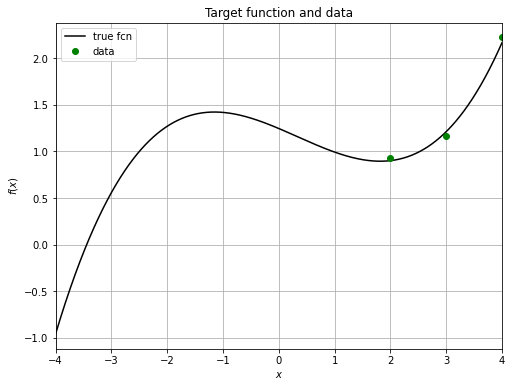

In [14]:
# We use spline interpolation to build the target function
target_func = UnivariateSpline(
    np.array([-4, -3,  -2,  -1,  0, 1, 2, 3, 4]),
    np.array([-1, 0.5, 1.5, 1.5, 1, 0.8, 1, 1.5, 2])
)

xs = np.linspace(-4,4,1000)
#ys = target_func(xs)

# Build the training set
# Small data set
xs_train = np.array([2,3,4])
# Larger data set
#xs_train = np.arange(-4,5)
noise_var = 0.1**2
ys_train = target_func(xs_train) + np.random.normal(loc=0, scale=np.sqrt(noise_var), size=len(xs_train))

# Plot the target function and data points
plt.figure(figsize=my_fig_size_single)
plt.plot(xs, target_func(xs), 'black',label='true fcn')
plt.plot(xs_train, ys_train, 'go',label='data')
plt.xlim([-4,4])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
_ = plt.title('Target function and data')
plt.grid('on')
plt.legend()

### Model (prior)

We consider affine $\phi(x)=(1,x)$, quadratic $\phi(x)=(1,x,x^2)$ and cubic $\phi(x)=(1,x,x^2,x^3)$ features.

In [15]:
def features_affine(xs):
    return np.hstack([np.ones(len(xs)).reshape([-1,1]), xs.reshape([-1,1])])

def features_quadratic(xs):
     return np.hstack([
         np.ones(len(xs)).reshape([-1,1]), 
         xs.reshape([-1,1]),
         xs.reshape([-1,1])**2
     ])
    
def features_cubic(xs):
    return np.hstack([
         np.ones(len(xs)).reshape([-1,1]), 
         xs.reshape([-1,1]),
         xs.reshape([-1,1])**2,
         xs.reshape([-1,1])**3,
     ])
get_features = features_cubic

In [16]:
Phi = get_features(xs_train)

As a prior on the weights $w$ (note that the number of weights depends on the number of features)
we use an isotropic normal distribution with mean zero and the identity as covariance matrix.

In [17]:
n_features = Phi.shape[1]
w_prior_mean = np.zeros(n_features)
w_prior_cov = np.eye(n_features)

For illustration, we plot function mean, std (shaded region), and we draw some samples from the prior distribution and plot the induced functions.

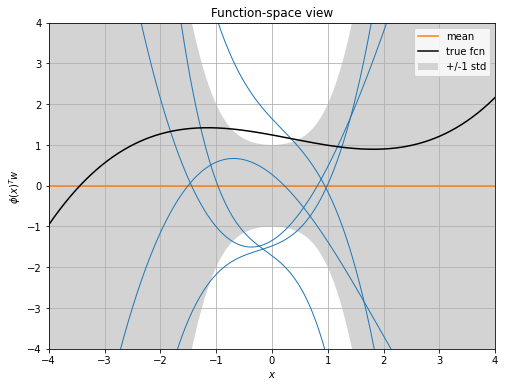

In [18]:
plt.figure(figsize=my_fig_size_single)

# compute mean and std of function values
Phi_plot = get_features(xs)
f_mean = Phi_plot @ w_prior_mean
f_cov = Phi_plot @ w_prior_cov @ Phi_plot.transpose()
f_std = np.sqrt(np.diag(f_cov))

# plot mean and std in function space
plt.plot(xs,f_mean,'tab:orange',label='mean')
plt.fill_between(xs,n_plot_std*f_std+f_mean,-n_plot_std*f_std+f_mean,facecolor='lightgrey',label='+/-1 std')

# samples
for i in range(n_sample_funcs):
    w = np.random.multivariate_normal(w_prior_mean, w_prior_cov, size=1)[0,:]
    plt.plot(xs, Phi_plot @ w, 'tab:blue', lw=1)

plt.plot(xs, target_func(xs), 'black',label='true fcn')
plt.grid('on')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('$x$')
plt.ylabel('$\phi(x)^T w$')
_ = plt.title('Function-space view')
plt.legend()

### Posterior

Using the likelihood we arrive at the posterior distribution, again a multivariate normal distribution.

In [19]:
w_post_cov = la.inv(la.inv(w_prior_cov) + 1/noise_var*Phi.T @ Phi)
w_post_mean = w_post_cov @ (la.inv(w_prior_cov) @ w_prior_mean + 1/noise_var*Phi.T @ ys_train)

Plotting posterior mean, variance and some samples. 

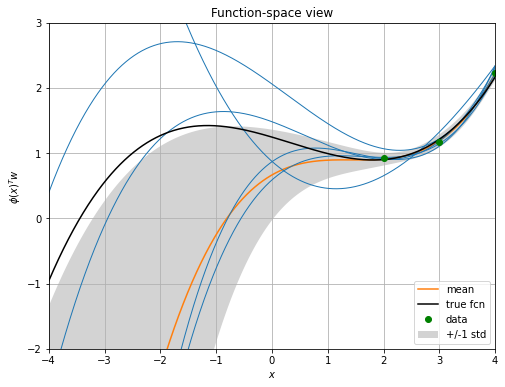

In [20]:
plt.figure(figsize=my_fig_size_single)

# compute mean and std of function values
Phi_plot = get_features(xs)
f_mean = Phi_plot @ w_post_mean
f_cov = Phi_plot @ w_post_cov @ Phi_plot.transpose()
f_std = np.sqrt(np.diag(f_cov))

# plot mean and std in function space
plt.plot(xs,f_mean,'tab:orange',label='mean')
plt.fill_between(xs,n_plot_std*f_std+f_mean,-n_plot_std*f_std+f_mean,facecolor='lightgrey',label='+/-1 std')

# samples
for i in range(n_sample_funcs):
    w = np.random.multivariate_normal(w_post_mean, w_post_cov, size=1)[0,:]
    plt.plot(xs, Phi_plot @ w, 'tab:blue', lw=1)

plt.plot(xs, target_func(xs), 'black',label='true fcn')
plt.plot(xs_train, ys_train, 'go',label='data')
plt.grid('on')
plt.ylim([-2,3])
plt.xlim([-4,4])
plt.xlabel('$x$')
plt.ylabel('$\phi(x)^T w$')
_ = plt.title('Function-space view')
plt.legend()